In [1]:
import numpy as np
import h5py as h5
import sys
import time

In [2]:
# Parse Arguement
run_num = 29 #int(sys.argv[1])


# Define parameters -- update!
exp_name = 'xppl1001021'
output_path = '/sdf/data/lcls/ds/xpp/{}/results/output/'.format(exp_name)
smalldata_path = '/sdf/data/lcls/ds/xpp/{}/hdf5/smalldata/'.format(exp_name)

# Define functions
def reconstruct_img(photons_i, photons_j, shape):
    nx, ny = shape
    phot_img, _,_ = np.histogram2d(photons_j+0.5, photons_i+0.5, bins=[np.arange(nx+1),np.arange(ny+1)])                         
    return phot_img


In [4]:
N_epix = 4
#user_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/kyounes/mask/standard_mask.npy')
#user_mask = user_mask.astype(bool)


# Load the result from droplet analysis
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    print(f.keys())
    photons_i = []
    photons_j = []
    
    total_mask = []#this is the general mask we use for photonization
    
    for epix in range(N_epix):
        print(epix+1)
        photons_j.append( f['epix_alc{}/ragged_droplet_photon_j'.format(epix+1)][:])
        photons_i.append( f['epix_alc{}/ragged_droplet_photon_i'.format(epix+1)][:])
        mask =      f['UserDataCfg/epix_alc{}/mask'.format(epix+1)][()]
        # Load all the masks
        mask = mask.astype(bool)
        bad_pixel_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/haoyuan/mask_epix{}_combined_hy_v1.npy'.format(epix+1))
        total_mask.append((mask  * bad_pixel_mask).astype(bool))

    i_sample = f['lombpm']['channels'][:,1]
    cc = np.array(f['ai/ch03'])
    vcc = np.array(f['ai/ch02'])
    


# Process each pattern in this run
shape = mask.shape
nframe = int(len(photons_i[0]))
#imgs_reconstruct = np.zeros(np.r_[nframe, shape])

pixel_num = float(np.sum(total_mask))

# Create holders for the result
kbar = np.zeros(nframe)
p0 = np.zeros(nframe)
p1 = np.zeros(nframe)
p2 = np.zeros(nframe)
p3 = np.zeros(nframe)

# Get the total photon count and probability per shot for all runs and patterns
tic = time.time()
for i in range(nframe):
    kbar[i] = 0
    p0[i] = 0
    p1[i] = 0
    p2[i] = 0
    p3[i] = 0

    
    for epix in range (N_epix):
        imgs_reconstruct = reconstruct_img(photons_i[epix][i], photons_j[epix][i], shape)
        kbar[i] += np.sum(imgs_reconstruct[total_mask[epix]])/ pixel_num
        p, p_bin_edge = np.histogram(imgs_reconstruct[total_mask[epix]].flatten(),bins=[-0.5, 0.5, 1.5, 2.5, 3.5])
    
        p0[i] += p[0] / pixel_num
        p1[i] += p[1] / pixel_num
        p2[i] += p[2] / pixel_num
        p3[i] += p[3] / pixel_num

    # if i // 1000 == 0:
    #     toc = time.time()
    #     print(toc - tic)
        
# Get the analytical contrast expression

#beta_2ph = (2 * p2 - kbar * p1) / (kbar * (p1 - 2 * p2))




# beta = (2 * p2 - kbar * p1) / (kbar * (p1 - 2 * p2))
# #np.savez(output_path + 'contrast_run_{}_delay_{}_pulse_{}'.format(run_num, delay, pulse),## this would be ideal but not implemented
# np.savez(output_path + 'test_contrast_run_{}'.format(run_num),
#          beta=beta,
#          p1=p1,
#          p2=p2,
#          p0=p0,
#          p3=p3,
#          kbar=kbar,
#          cc=cc,
#          vcc=vcc,
#          i_sample=i_sample)

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'adc', 'ai', 'damage', 'diode2', 'diodeU', 'ebeam', 'epics', 'epicsAll', 'epix_alc1', 'epix_alc1_env', 'epix_alc2', 'epix_alc2_env', 'epix_alc3', 'epix_alc3_env', 'epix_alc4', 'epix_alc4_env', 'epix_alc5', 'epix_alc5_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'gas_detector', 'ipm2', 'ipm_hx2', 'lightStatus', 'lombpm', 'lomdiode', 'scan']>
1
2
3
4


In [5]:
np.shape(imgs_reconstruct)

(704, 768)

# see output results

In [9]:
output_path = '/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/output/'

In [8]:
!ls /sdf/data/lcls/ds/xpp/xppl1001021/results/shared/output/

contrast_run_46.npz


In [10]:
f = np.load(output_path + 'contrast_run_46.npz')
f.files

['beta', 'p1', 'p2', 'p0', 'p3', 'kbar', 'cc', 'vcc', 'i_sample']

In [12]:
data = {}
for key in f.files:
    data[key] = f[key]
    print(key, np.shape(data[key]))

beta (4, 17515)
p1 (4, 17515)
p2 (4, 17515)
p0 (4, 17515)
p3 (4, 17515)
kbar (4, 17515)
cc (17515,)
vcc (17515,)
i_sample (17515,)


In [14]:
from matplotlib import pyplot as plt

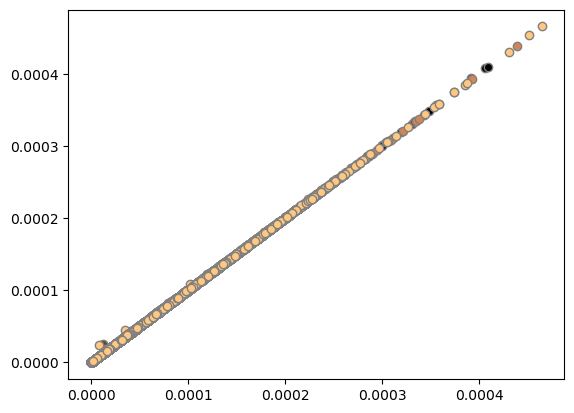

In [19]:
plt.figure()
nepix = 4
col = plt.cm.copper(np.linspace(0,1,nepix))
for i in range(nepix):
    plt.plot(data['p1'][i,:], data['kbar'][i,:], c=col[i], ls='', marker='o', mec='gray', label=f'epix{i+1}')
    plt.plot(data['p1'][i,:], data['kbar'][i,:], c=col[i], ls='', marker='o', mec='gray', label=f'epix{i+1}')
# plt.xlim(0,10)